### [Extract Text from *PDFs](https://)*

In [15]:
# @title Default title text
# Install necessary libraries
!pip install PyMuPDF sentence-transformers pinecone-client
!pip install transformers

### Maintaining User Context

In [77]:
# Initialize query history list
query_history = []
def add_to_history(original_query, refined_query):
    global query_history
    if len(query_history) >= 5:
        query_history.pop(0)  # Remove the oldest query
    query_history.append((original_query, refined_query))

def get_context():
    global query_history
    context = "Previous queries and their refined versions:\n"
    for i, (original_query, refined_query) in enumerate(query_history):
        context += f"Q{i+1}: {original_query}\nRefined Q{i+1}: {refined_query}\n"
    return context

### Helper functions

In [79]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np

# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt_model = GPT2LMHeadModel.from_pretrained("gpt2")

### extract text from pdf
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text += page.get_text()
    doc.close()
    return text

# Text into segments
def chunk_text_by_sentence(text, max_chunk_size=1000):
    chunks = []
    current_chunk = ""
    for i in range(0, len(text), max_chunk_size):
        chunks.append(text[i:i + max_chunk_size])
    return chunks

### Generate Embedding
def generate_embeddings(chunks, batch_size=32):
    embeddings = []
    for i in range(0, len(chunks), batch_size):
        batch = chunks[i:i+batch_size]
        batch_embeddings = model.encode(batch)
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

### Query pinecone
def query_pinecone(query, top_k=5, namespace=None):
    query_embedding = model.encode([query]).tolist()[0]
    result = index.query(
        vector=query_embedding,
        top_k=top_k,
        namespace=namespace,
        include_values=True
    )
    return result

def handle_user_query(query):
    refined_query = refine_query(query)

    answer = query_pinecone(refined_query)

    return answer

def save_embedding(embeddings,PINECONE_API_KEY,index_name):
    # Initialize Pinecone with the API key
    pc = Pinecone(
        api_key=PINECONE_API_KEY
    )

    # Connect to an existing index
    index_name = 'nagp'
    index = pc.Index(index_name)

    # Store embeddings in Pinecone
    vectors = [(str(i), embedding.tolist()) for i, embedding in enumerate(embeddings)]
    index.upsert(vectors)
    return f"Embeddings stored in Pinecone index '{index_name}'."

def refine_query(query):
    global query_history

    # Construct the prompt with detailed instructions
    prompt = (
        f"The user is trying to find specific information online and needs help refining their search query. "
        f"Here is the original query:\n\n"
        f"Original Query: {query}\n\n"
        f"Please rewrite this query to be more specific, include relevant keywords, and remove any ambiguity. "
        f"The refined query should be more likely to yield precise and relevant search results.\n\n"
        f"Refined Query:"
    )

    # Tokenize the input prompt
    inputs_up = tokenizer(prompt, return_tensors='pt')

    # Generate the refined query
    outputs_up = gpt_model.generate(
        inputs_up['input_ids'],
        max_length=100,  # Adjust max_length for appropriate response size
        temperature=0.3,
        do_sample=True,
        top_p=0.90,  # Use nucleus sampling for better quality responses
        num_return_sequences=1  # Generate only one refined query
    )
    refined_query_up = tokenizer.decode(outputs_up[0], skip_special_tokens=True)

    # Extract the refined query from the model output
    refined_query_up = refined_query_up.split("Refined Query:")[1].strip() if "Refined Query:" in refined_query_up else refined_query_up.strip()

    # Add the original query and its refined version to history
    add_to_history(query, refined_query_up)

    return refined_query_up

def print_matching_chunks(result, text_chunks):
    for match in result['matches']:
        match_id = int(match['id'])
        if match_id < len(text_chunks):
            print(f"ID: {match_id}, Score: {match['score']}, Text Chunk: {text_chunks[match_id]}")


### Extract text from PDF

In [17]:
import fitz  # PyMuPDF

pdf_path = 'Assignment Support Document.pdf'
text = extract_text_from_pdf(pdf_path)

### Segment Text into Chunks

In [18]:
text_chunks = chunk_text_by_sentence(text)

### Generate Embeddings

In [19]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = generate_embeddings(text_chunks)
print(embeddings.shape)  # Print the shape of the embeddings

(36, 384)


### Store and Retrieve Embeddings

In [20]:
import os
from pinecone import Pinecone, ServerlessSpec
import numpy as np

#print(embeddings)
# Set your Pinecone API key
PINECONE_API_KEY = '8a0d1246-0203-463f-b6db-b467b4b78927'
index_name = 'nagp'

save_result = save_embedding(embeddings,PINECONE_API_KEY,index_name)
print(save_result)

# Example query
#query_result = query_pinecone("Mudra Yojana", top_k=3, namespace=None)
#print(query_result)

Embeddings stored in Pinecone index 'nagp'.


### Integrate GPT model

In [10]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
gpt_model = GPT2LMHeadModel.from_pretrained(model_name)

### Query text

In [129]:
query = "Prime Minister of India"

### Query the Vector Database and Get refine query to perform search

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


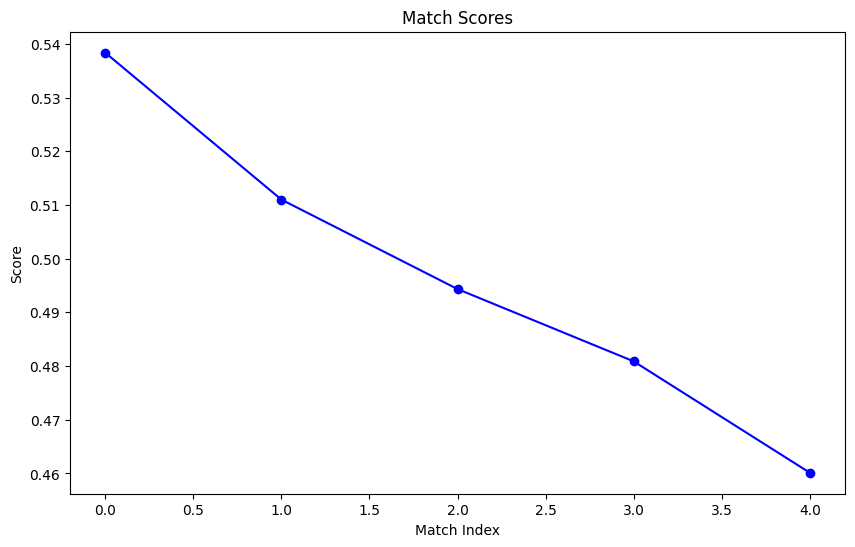

ID: 0, Score: 0.53835994
ID: 27, Score: 0.511003554
ID: 13, Score: 0.494339496
ID: 35, Score: 0.480876505
ID: 12, Score: 0.460132092
Average Score: 0.4969423174


In [133]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def run_search_query(query):
    # Use the query_pinecone function to get results
    result = query_pinecone(query)
    # Assuming result['matches'] is a list of ScoredVector objects
    if 'matches' in result:
        return result['matches']  # Return all matches for inspection
    else:
        return []

def analyze_results(matches):
    # Extract scores
    scores = [match['score'] for match in matches]

    # Plot scores
    plt.figure(figsize=(10, 6))
    plt.plot(scores, marker='o', linestyle='-', color='b')
    plt.title('Match Scores')
    plt.xlabel('Match Index')
    plt.ylabel('Score')
    plt.show()

    # Print top 5 matches
    top_matches = sorted(matches, key=lambda x: x['score'], reverse=True)[:5]
    for match in top_matches:
        print(f"ID: {match['id']}, Score: {match['score']}")

    # Calculate average score
    average_score = np.mean(scores)
    print(f"Average Score: {average_score}")

refined_query = refine_query(query)
matches = run_search_query(refined_query)
analyze_results(matches)
#result = query_pinecone(refined_query)
#print_matching_chunks(result, text_chunks)

